In [29]:
import torch
print(torch.__version__)
import torch
import numpy as np

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from utilities import *
from nn_conv import NNConv, NNConv_old

from timeit import default_timer
import scipy.io

1.12.0+cu116


In [30]:
def normalizer(data):
    max_resp = []
    max_strain = []
    for j in range(len(data)):
        max_resp.append(max(data[j][2][:,0])) #epsilon_xx
        max_strain.append(max(data[j][1][:,0])) #epsilon_xx           
    mmax_strain = max(max_strain)
    mmax_resp = max(max_resp)
    mmax_coor = 200 #max(data[0][0,:])
    for j in range(len(data)):
        data[j][0] = data[j][0]/mmax_coor
        data[j][1] = data[j][1]/mmax_strain
        data[j][2] = (data[j][2])/mmax_resp
    return data, mmax_strain, mmax_resp, mmax_coor


def normalizer_t(data, mmax_strain, mmax_resp, mmax_coor):
    for j in range(len(data)):
        mmax_coor = max(data[j][0])
        data[j][0] = data[j][0]/mmax_coor
        data[j][1] = data[j][1]/mmax_strain
        data[j][2] = data[j][2]/mmax_resp
    return data


def denormalizer(coor, resp, pred, mmax_strain, mmax_resp, mmax_coor):
    coor = coor * mmax_coor
    resp = resp * mmax_resp
    pred = pred * mmax_resp
    return coor, resp, pred

class SCAMeshGenerator():
    def __init__(self, grid, input, output):
        self.grid = grid.reshape(-1,2)
        self.input = input
        self.output = output[:,1]
        self.d  = 2
    
    def get_grid(self):
        return torch.tensor(self.grid, dtype=torch.float)

    def get_input(self):
        return torch.tensor(self.input, dtype=torch.float)

    def get_output(self):
        return torch.tensor(self.output, dtype=torch.float)

    def ball_connectivity(self, r):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        self.edge_index = np.vstack(np.where(pwd <= r))
        self.n_edges = self.edge_index.shape[1]

        return torch.tensor(self.edge_index, dtype=torch.long)

    def gaussian_connectivity(self, sigma):
        pwd = sklearn.metrics.pairwise_distances(self.grid)
        rbf = np.exp(-pwd**2/sigma**2)
        sample = np.random.binomial(1,rbf)
        self.edge_index = np.vstack(np.where(sample))
        self.n_edges = self.edge_index.shape[1]
        return torch.tensor(self.edge_index, dtype=torch.long)


    def attributes(self, f=None, theta=None):
        if f is None:
            if theta is None:
                edge_attr = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            else:
                edge_attr = np.zeros((self.n_edges, 2*self.d + 6))
                edge_attr[:, 0:2*self.d] = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
                edge_attr[:, 2 * self.d     : 2 * self.d + 3] = theta[self.edge_index[0]]
                edge_attr[:, 2 * self.d + 3 : 2 * self.d + 6] = theta[self.edge_index[1]]
        else:
            xy = self.grid[self.edge_index.T].reshape((self.n_edges,-1))
            if theta is None:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:])
            else:
                edge_attr = f(xy[:,0:self.d], xy[:,self.d:], theta[self.edge_index[0]], theta[self.edge_index[1]])

        return torch.tensor(edge_attr, dtype=torch.float)

In [31]:
Nn = 2000
#import raw data from matlab files
grid8inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_8.mat'
grid8matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_8.mat'

epsilon8_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_8.mat'



reader = MatReader(grid8inclusion_path)
grid8inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid8matrix_path)
grid8matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon8_path)
epsilon8 = reader.read_field('etotal_list')[:,1:Nn]

grid8 = torch.cat((grid8inclusion, grid8matrix), 0) 

grid12inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_12.mat'
grid12matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_12.mat'

epsilon12_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_12.mat'



reader = MatReader(grid12inclusion_path)
grid12inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid12matrix_path)
grid12matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon12_path)
epsilon12 = reader.read_field('etotal_list')[:,1:Nn]

grid12 = torch.cat((grid12inclusion, grid12matrix), 0) 

grid16inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_16.mat'
grid16matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_16.mat'

epsilon16_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_16.mat'


reader = MatReader(grid16inclusion_path)
grid16inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid16matrix_path)
grid16matrix = reader.read_field('Cmm')[:,1:3]

grid16 = torch.cat((grid16inclusion, grid16matrix), 0) 

reader = MatReader(epsilon16_path)
epsilon16 = reader.read_field('etotal_list')[:,1:Nn]



grid24inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_24.mat'
grid24matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_24.mat'

epsilon24_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_24.mat'



reader = MatReader(grid24inclusion_path)
grid24inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid24matrix_path)
grid24matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon24_path)
epsilon24 = reader.read_field('etotal_list')[:,1:Nn]

grid24 = torch.cat((grid24inclusion, grid24matrix), 0) 



grid28inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_28.mat'
grid28matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_28.mat'

epsilon28_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_28.mat'



reader = MatReader(grid28inclusion_path)
grid28inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid28matrix_path)
grid28matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon28_path)
epsilon28 = reader.read_field('etotal_list')[:,1:Nn]

grid28 = torch.cat((grid28inclusion, grid28matrix), 0) 


grid48inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_48.mat'
grid48matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_48.mat'

epsilon48_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_48.mat'



reader = MatReader(grid48inclusion_path)
grid48inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid48matrix_path)
grid48matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon48_path)
epsilon48 = reader.read_field('etotal_list')[:,1:Nn]

grid48 = torch.cat((grid48inclusion, grid48matrix), 0) 


grid56inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_56.mat'
grid56matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_56.mat'

epsilon56_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_56.mat'



reader = MatReader(grid56inclusion_path)
grid56inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid56matrix_path)
grid56matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon56_path)
epsilon56 = reader.read_field('etotal_list')[:,1:Nn]

grid56 = torch.cat((grid56inclusion, grid56matrix), 0)


grid64inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_64.mat'
grid64matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_64.mat'

epsilon64_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_64.mat'



reader = MatReader(grid64inclusion_path)
grid64inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid64matrix_path)
grid64matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon64_path)
epsilon64 = reader.read_field('etotal_list')[:,1:Nn]

grid64 = torch.cat((grid64inclusion, grid64matrix), 0) 

grid96inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_96.mat'
grid96matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_96.mat'

epsilon96_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_96.mat'



reader = MatReader(grid96inclusion_path)
grid96inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid96matrix_path)
grid96matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon96_path)
epsilon96 = reader.read_field('etotal_list')[:,1:Nn]

grid96 = torch.cat((grid96inclusion, grid96matrix), 0)



# In[18]:


grid8.size()[0]


# In[19]:


#organize data in the training testing format
Nn=Nn-1
data = []
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid8
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid8.size()[0],1])
  data0[2] = epsilon8[:,i].reshape(16, 6)[:,[0,1,5]]
  data.append(data0)
  
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid12
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid12.size()[0],1])
  data0[2] = epsilon12[:,i].reshape(24, 6)[:,[0,1,5]]
  data.append(data0)
  
for i in range(Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid16
  pbc = torch.tensor([0.0001 *i, 0, 0])
  data0[1] = pbc.repeat([grid16.size()[0],1])
  data0[2] = epsilon16[:,i].reshape(32, 6)[:,[0,1,5]]
  data.append(data0)
  
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid24
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid24.size()[0],1])
  data0[2] = epsilon24[:,i].reshape(48, 6)[:,[0,1,5]]
  data.append(data0)
  
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid28
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid28.size()[0],1])
  data0[2] = epsilon28[:,i].reshape(56, 6)[:,[0,1,5]]
  data.append(data0)

  
for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid48
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid48.size()[0],1])
  data0[2] = epsilon48[:,i].reshape(96, 6)[:,[0,1,5]]
  data.append(data0)

for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid56
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid56.size()[0],1])
  data0[2] = epsilon56[:,i].reshape(112, 6)[:,[0,1,5]]
  data.append(data0)


for i in range(Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid64
  pbc = torch.tensor([0.0001 *i, 0, 0])
  data0[1] = pbc.repeat([grid64.size()[0],1])
  data0[2] = epsilon64[:,i].reshape(128, 6)[:,[0,1,5]]
  data.append(data0)

for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid96
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid96.size()[0],1])
  data0[2] = epsilon96[:,i].reshape(192, 6)[:,[0,1,5]]
  data.append(data0)

In [32]:
max_resp = []
max_strain = []
for j in range(len(data)):
    max_resp.append(max(data[j][2][:,0])) #epsilon_xx
    max_strain.append(max(data[j][1][:,0])) #epsilon_xx           
mmax_strain = max(max_strain)
mmax_resp = max(max_resp)
mmax_coor = 200 #max(data[0][0,:])
for j in range(len(data)):
    data[j][0] = data[j][0]/mmax_coor
    data[j][1] = data[j][1]/mmax_strain
    data[j][2] = (data[j][2])/mmax_resp


# In[21]:


len(data)


17984

In [33]:
class KernelNN(torch.nn.Module):
    def __init__(self, width, ker_width, depth, ker_in, in_width=1, out_width=1):
        super(KernelNN, self).__init__()
        self.depth = depth

        self.fc1 = torch.nn.Linear(in_width, width)

        kernel = DenseNet([ker_in, ker_width//2, ker_width, width**2], torch.nn.ReLU)
        self.conv1 = NNConv_old(width, width, kernel, aggr='mean')

        self.fc2 = torch.nn.Linear(width, ker_width)
        self.fc3 = torch.nn.Linear(ker_width, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.fc1(x)
        for k in range(self.depth):
            x = self.conv1(x, edge_index, edge_attr)
            if k != self.depth-1:
                x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


# In[23]:


ntrain = 7000
ntest  = 995



t1 = default_timer()
batch_size  = 100 # factor of ntrain * k
batch_size2 = 100 # factor of test_split

radius_train = 0.4
radius_test = 0.4
# rbf_sigma = 0.2



# In[24]:


width = 50
ker_width = 800
depth = 5
edge_features = 10
node_features = 5

epochs = 100
learning_rate = 0.0001
scheduler_step = 10
scheduler_gamma = 0.85


In [34]:
model2 = torch.load('/home/jgz1751/Kernel_learning/code/GKN2D_moredata_d75_30_inc_replicate.pt') #trained using 100 epochs

batch_size = 1

In [35]:
#Nn = 2000
Nn = 1500
#import raw data from matlab files

grid32inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_32.mat'
grid32matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_32.mat'

epsilon32_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_32.mat'
reader = MatReader(grid32inclusion_path)
grid32inclusion = reader.read_field('Cii')[:,1:3]

reader = MatReader(grid32matrix_path)
grid32matrix = reader.read_field('Cmm')[:,1:3]

reader = MatReader(epsilon32_path)
epsilon32 = reader.read_field('etotal_list')[:,1:Nn]

grid32 = torch.cat((grid32inclusion, grid32matrix), 0)

# grid128inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12n_128.mat'
# grid128matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12n_128.mat'

# epsilon128_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12_128.mat'
# reader = MatReader(grid128inclusion_path)
# grid128inclusion = reader.read_field('Cii')[:,1:3]

# reader = MatReader(grid128matrix_path)
# grid128matrix = reader.read_field('Cmm')[:,1:3]

# reader = MatReader(epsilon128_path)
# epsilon128 = reader.read_field('etotal_list')[:,1:Nn]

# grid128 = torch.cat((grid128inclusion, grid128matrix), 0)

# grid32inclusion_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_inclusion_vf12d150_32.mat'
# grid32matrix_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/centroid_matrix_vf12d150_32.mat'

# epsilon32_path = '/home/jgz1751/Kernel_learning/data/2D_Data/ToJiachen_data/epsilon_vf12d150_32.mat'
# reader = MatReader(grid32inclusion_path)
# grid32inclusion = reader.read_field('Cii')[:,1:3]

# reader = MatReader(grid32matrix_path)
# grid32matrix = reader.read_field('Cmm')[:,1:3]

# reader = MatReader(epsilon32_path)
# epsilon32 = reader.read_field('etotal_list')[:,1:Nn]

# grid32 = torch.cat((grid32inclusion, grid32matrix), 0)

In [36]:
mmax_coor

200

In [39]:
Nn=Nn-1
data_test = []
# for i in range(1, Nn):
#   data0 =[[1],[2],[3]]
#   data0[0] = grid32
#   pbc = torch.tensor([0.0001 * i, 0, 0])
#   data0[1] = pbc.repeat([grid32.size()[0],1])
#   data0[2] = epsilon32[:,i].reshape(64, 6)[:,[0,1,5]]
#   data_test.append(data0)

for i in range(1, Nn):
  data0 =[[1],[2],[3]]
  data0[0] = grid32
  pbc = torch.tensor([0.0001 * i, 0, 0])
  data0[1] = pbc.repeat([grid32.size()[0],1])
  data0[2] = epsilon32[:,i].reshape(64, 6)[:,[0,1,5]]
  data_test.append(data0)

for j in range(len(data_test)):
  data_test[j][0] = data_test[j][0]/75
  data_test[j][1] = data_test[j][1]/mmax_strain
  data_test[j][2] = (data_test[j][2])/mmax_resp


# In[ ]:


data_vali=[]
j = 1200
grid = data_test[j][0]
input = data_test[j][1]
output = data_test[j][2]
meshgenerator = SCAMeshGenerator(grid, input, output)
grid = meshgenerator.get_grid()
input = meshgenerator.get_input()
output = meshgenerator.get_output()

edge_index = meshgenerator.ball_connectivity(radius_test)
print(grid.size())
print(edge_index.size())

edge_attr = meshgenerator.attributes(theta = input)
print(edge_attr.size())
# data_train.append(Data(x=init_point.clone().view(-1,1), y=train_y[j,:], edge_index=edge_index, edge_attr=edge_attr))
data_vali.append(Data(x=torch.cat([grid.reshape(-1, 2), input.reshape(-1, 3)], dim=1),X=grid, y=output, edge_index=edge_index, edge_attr=edge_attr))

train_vali = DataLoader(data_vali, batch_size=batch_size, shuffle=True)

torch.Size([64, 2])
torch.Size([2, 1234])
torch.Size([1234, 10])


/tmp/ipykernel_2616461/3960597662.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.grid, dtype=torch.float)
/tmp/ipykernel_2616461/3960597662.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.input, dtype=torch.float)
/tmp/ipykernel_2616461/3960597662.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.output, dtype=torch.float)
/home/jgz1751/conda_env/GKN/lib/python3.10/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is depr

0.9369958965007135


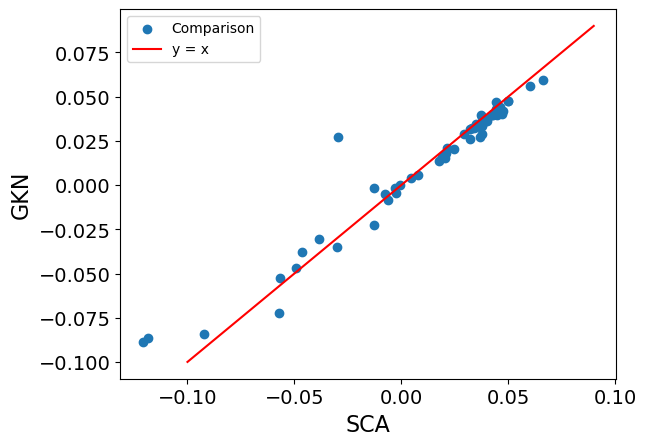

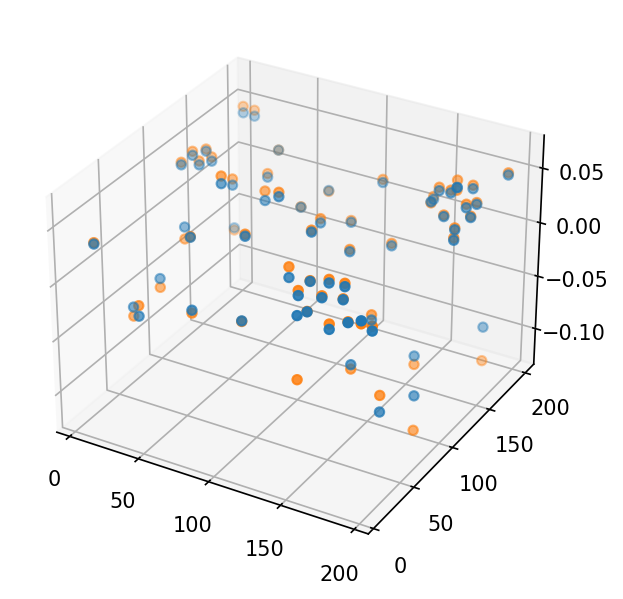

In [40]:
with torch.no_grad():
      for batch in train_vali:
          batch = batch.to(device)
          out = model2(batch).detach().cpu()
          pred = batch.y.view(batch_size, -1).cpu()
out = out.numpy()
pred = pred.numpy()
pred = pred.flatten()
coor = batch.X.view(batch_size, -1).cpu().numpy().reshape(-1,1)

#coor, out, pred = denormalizer(coor, out, pred, mmax_strain, mmax_resp, mmax_coor)

out0 = out
pred0 = pred


plt.figure(dpi = 100)
plt.scatter(pred0, out0, label = 'Comparison') #assume amplitude 0.2


plt.xlabel('SCA',fontsize=16)
plt.ylabel('GKN',fontsize=16)
x=np.arange(-0.1, 0.1, 0.01)
y = x 

plt.plot(x,y, label = 'y = x', color = 'r')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.savefig("/home/jgz1751/Kernel_learning/code/newtest_r2.png", dpi = 300)

from sklearn.metrics import r2_score
print(r2_score(pred0, out0))

coor = batch.X.view(len(batch.X), 2).cpu().numpy()
coor = coor * 200
X = coor[:,0]
Y = coor[:,1]
Z = out
Z0 = pred
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z)
ax.scatter(X, Y, Z0)


scipy.io.savemat('Pred_128_large_strain.mat', dict(predx=Z*mmax_resp.cpu().numpy()))
scipy.io.savemat('Truth_128_large_strain.mat', dict(truthx=Z0*mmax_resp.cpu().numpy()))